In [1]:
import numpy as np
import h5py
import torch
from haar_noising_script import apply_haar_scrambling

QG_channel = 1
filename = f"../../../data/QG{QG_channel}_normalized_16x16_100k"
data_X = np.array(h5py.File(filename, "r")['X'])

num_samples = 100

encoded_data_load = torch.load(f"../../../data/Q{QG_channel}_16x16_1k_encoded.pt")
print(encoded_data_load.shape)

scrambled_states = apply_haar_scrambling(np.array(encoded_data_load), num_samples, seed=42)
scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32)
print(scrambled_states.shape)

C:\Users\realc\AppData\Local\Temp\ipykernel_9260\4263250224.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoded_data_load = torch.load(f"../../../data/Q{QG_channel}

torch.Size([1000, 8, 8, 4])
torch.Size([100, 8, 8, 4])


C:\Users\realc\AppData\Local\Temp\ipykernel_9260\4263250224.py:16: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Copy.cpp:305.)
  scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32)


In [2]:
'''Testing with non normalized or discretized images'''
import import_ipynb
import numpy as np
import h5py
import torch
from angle_encoding_script import angle_encoding
from haar_noising_script import apply_haar_scrambling

QG_channel = 1
filename = f"../../../data/QG{QG_channel}_16x16_1k"
data_X = np.array(h5py.File(filename, "r")['X'])

num_samples = 100

encoded_data = [angle_encoding(data_X, sample) for sample in range(num_samples)]
encoded_data = torch.tensor(np.array(encoded_data), dtype=torch.float32)
print(encoded_data.shape)

scrambled_states = apply_haar_scrambling(np.array(encoded_data), num_samples, seed=42)
scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32)
print(scrambled_states.shape)

torch.Size([100, 8, 8, 4])
torch.Size([100, 8, 8, 4])


C:\Users\realc\AppData\Local\Temp\ipykernel_3380\334184488.py:20: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Copy.cpp:305.)
  scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32)


Epoch [1/100], Loss: 0.8418, Val Loss: 0.7455
Epoch [2/100], Loss: 0.7460, Val Loss: 0.6596
Epoch [3/100], Loss: 0.6599, Val Loss: 0.5840
Epoch [4/100], Loss: 0.5842, Val Loss: 0.5185
Epoch [5/100], Loss: 0.5187, Val Loss: 0.4626
Epoch [6/100], Loss: 0.4628, Val Loss: 0.4153
Epoch [7/100], Loss: 0.4155, Val Loss: 0.3754
Epoch [8/100], Loss: 0.3757, Val Loss: 0.3418
Epoch [9/100], Loss: 0.3421, Val Loss: 0.3134
Epoch [10/100], Loss: 0.3138, Val Loss: 0.2893
Epoch [11/100], Loss: 0.2897, Val Loss: 0.2684
Epoch [12/100], Loss: 0.2689, Val Loss: 0.2502
Epoch [13/100], Loss: 0.2507, Val Loss: 0.2338
Epoch [14/100], Loss: 0.2345, Val Loss: 0.2190
Epoch [15/100], Loss: 0.2197, Val Loss: 0.2053
Epoch [16/100], Loss: 0.2062, Val Loss: 0.1927
Epoch [17/100], Loss: 0.1937, Val Loss: 0.1810
Epoch [18/100], Loss: 0.1821, Val Loss: 0.1702
Epoch [19/100], Loss: 0.1713, Val Loss: 0.1601
Epoch [20/100], Loss: 0.1614, Val Loss: 0.1509
Epoch [21/100], Loss: 0.1522, Val Loss: 0.1424
Epoch [22/100], Loss: 

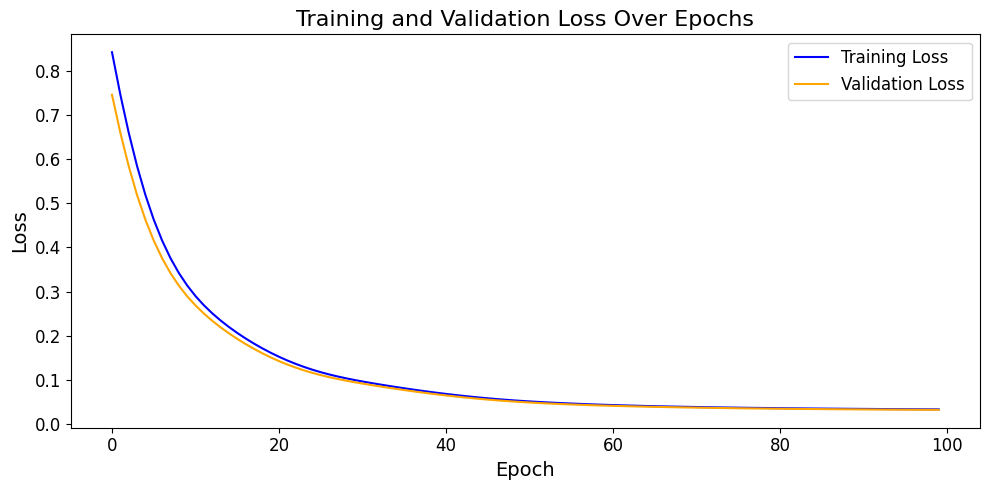

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy.linalg
import pennylane as qml

encoded_data = encoded_data_load

train_encoded_data, val_encoded_data, train_scrambled_states, val_scrambled_states = train_test_split(
    encoded_data[:num_samples], scrambled_states, test_size=0.2, random_state=42, shuffle=True
)

n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface='torch')
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class QuantumLayer(nn.Module):
    def __init__(self, n_qubits, n_layers):
        super(QuantumLayer, self).__init__()
        weight_shapes = {"weights": (n_layers, n_qubits, 3)}
        self.qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

    def forward(self, x):
        return self.qlayer(x)

class QuantumDiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_qubits, n_layers):
        super(QuantumDiffusionModel, self).__init__()
        self.n_qubits = n_qubits
        self.num_patches = input_dim // n_qubits
        
        self.quantum_layer = QuantumLayer(n_qubits, n_layers)
        
    def forward(self, x):
        x_patched = x.view(-1, self.num_patches, self.n_qubits)  # [batch_size, num_patches, n_qubits]

        output_patches = []
        for patch in range(self.num_patches):
            patch_out = self.quantum_layer(x_patched[:, patch])
            output_patches.append(patch_out)
        
        x = torch.cat(output_patches, dim=1)  # Concatenate all patches
        
        return x

def decode(encoded_data):
    num_samples, encoded_height, encoded_width, num_channels = encoded_data.shape
    decoded_data = np.zeros((num_samples, 16, 16))

    for sample in range(num_samples):
        for i in range(encoded_height):
            for j in range(encoded_width):
                for c in range(num_channels):
                    if c == 0:
                        decoded_data[sample, 2*i, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 1:
                        decoded_data[sample, 2*i, 2*j+1] = encoded_data[sample, i, j, c]
                    elif c == 2:
                        decoded_data[sample, 2*i+1, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 3:
                        decoded_data[sample, 2*i+1, 2*j+1] = encoded_data[sample, i, j, c]

    return decoded_data

def flip(decoded_data):
    return 1 - decoded_data

def calculate_statistics(data):
    data = data.reshape(data.shape[0], -1)
    mean = np.mean(data, axis=0)
    covariance = np.cov(data, rowvar=False)
    return mean, covariance

n_layers = 8
input_dim = 8 * 8 * 4
hidden_dim = 128
output_dim = input_dim  

model = QuantumDiffusionModel(input_dim, hidden_dim, output_dim, n_qubits, n_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100
loss_values = []
val_loss_values = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_scrambled_states.view(len(train_scrambled_states), -1))
    loss = criterion(outputs, train_encoded_data.view(len(train_encoded_data), -1))
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_scrambled_states.view(len(val_scrambled_states), -1))
        val_loss = criterion(val_outputs, val_encoded_data.view(len(val_encoded_data), -1))
        val_loss_values.append(val_loss.item())
        
        denoised_states = model(val_scrambled_states.view(len(val_scrambled_states), -1))
        denoised_states = denoised_states.view(len(val_scrambled_states), 8, 8, 4).detach().numpy()
        decoded_data = decode(denoised_states)
        decoded_data = flip(decoded_data)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

plt.figure(figsize=(10, 5))

plt.plot(loss_values, label='Training Loss', color='blue')
plt.plot(val_loss_values, label='Validation Loss', color='orange')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

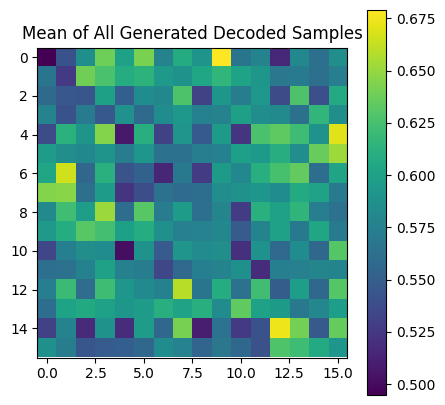

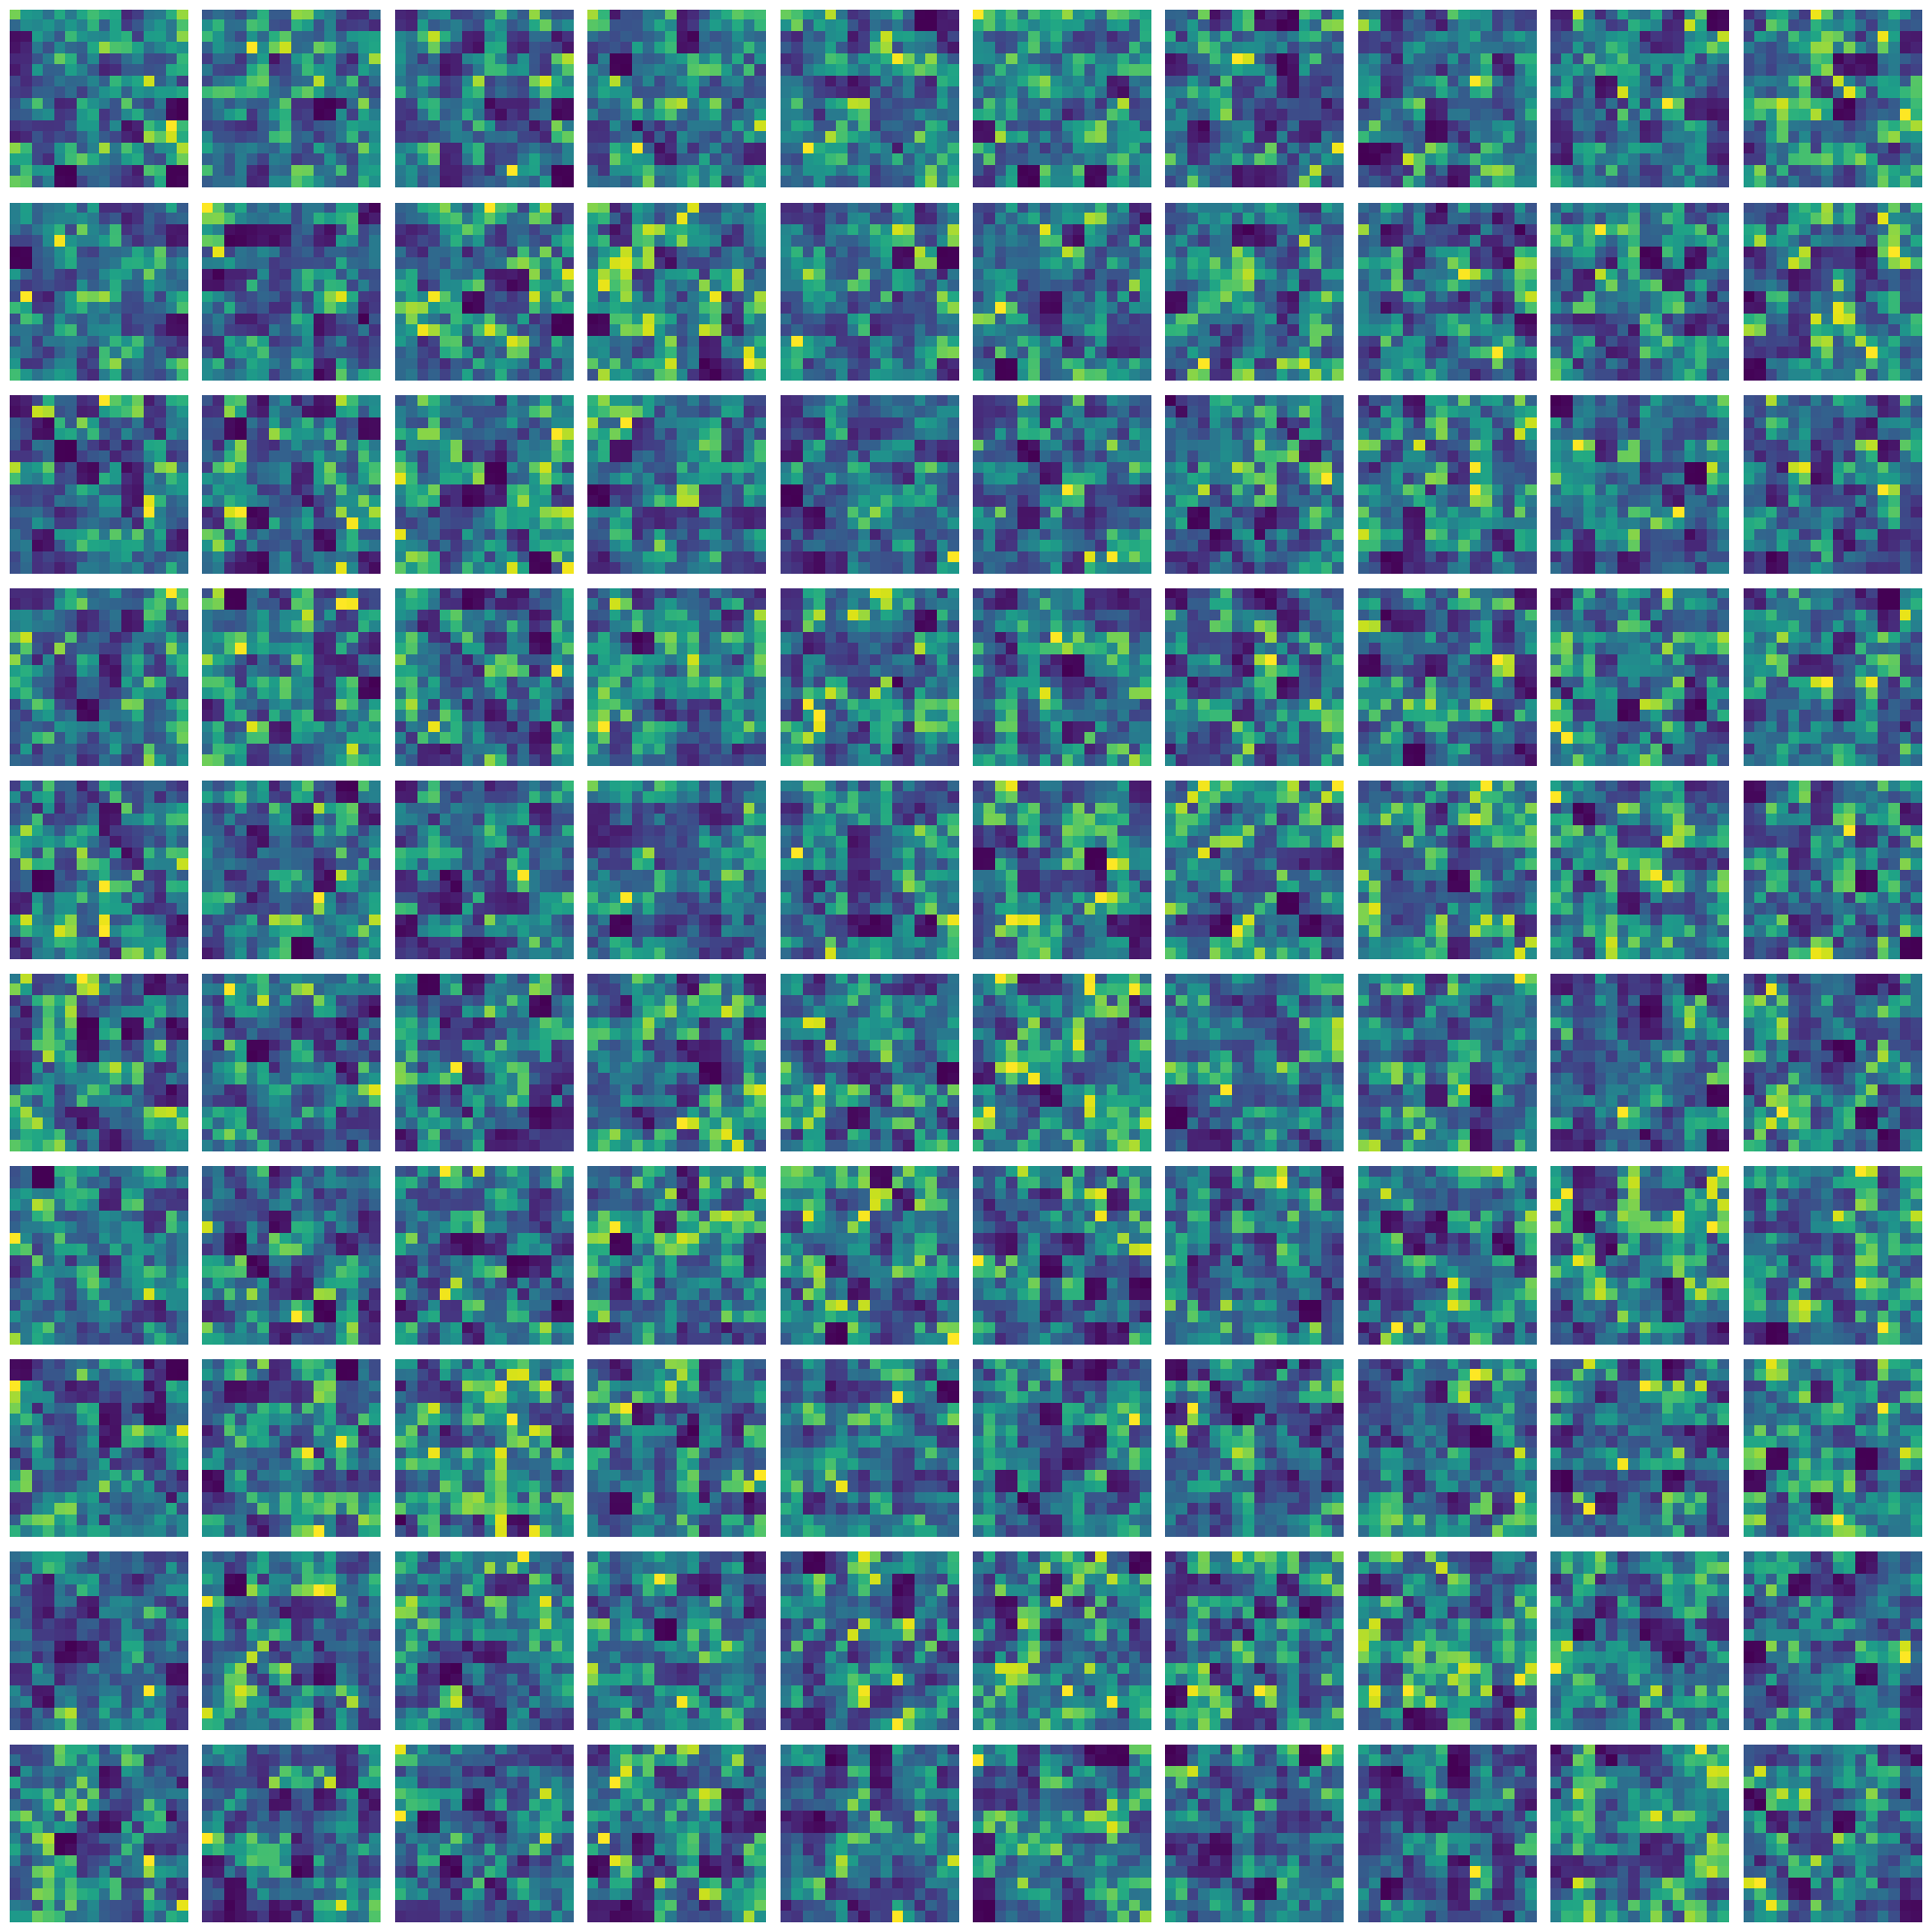

In [25]:
def generate_new_images(model, num_images, input_dim=8*8*4):
    model.eval()  
    with torch.no_grad():
        random_noise = torch.randn(num_images, input_dim)
        generated_data = model(random_noise)
        generated_data = flip(generated_data.view(num_images, 8, 8, 4).detach().numpy())
        decoded_images = decode(generated_data) 
        
        # for i in range(num_images):
        #     fig, axes = plt.subplots(1, 5, figsize=(10, 2))

        #     for qubit in range(4):
        #         im = axes[qubit].imshow(generated_data[i, :, :, qubit], cmap='viridis')
        #         axes[qubit].set_title(f"Encoded {qubit+1}")
        #         fig.colorbar(im, ax=axes[qubit])

        #     im = axes[4].imshow(decoded_images[i], cmap='viridis')
        #     axes[4].set_title("Decoded")
        #     fig.colorbar(im, ax=axes[4])
            
        #     plt.tight_layout()
        #     plt.show()

    return decoded_images

def plot_mean_decoded_images(decoded_images):
    mean_image = np.mean(decoded_images, axis=0)

    plt.figure(figsize=(5, 5))
    plt.imshow(mean_image, cmap='viridis')
    plt.title("Mean of All Generated Decoded Samples")
    plt.colorbar()
    plt.show()

def plot_all_decoded_images(decoded_images, grid_size=(10, 10)):
    num_images = decoded_images.shape[0]
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(20, 20))

    image_idx = 0
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            if image_idx < num_images:
                axes[i, j].imshow(decoded_images[image_idx], cmap='viridis')
                axes[i, j].axis('off')
                image_idx += 1
            else:
                axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

num_samples_to_generate = 100
new_images = generate_new_images(model, num_samples_to_generate)
plot_mean_decoded_images(new_images)
plot_all_decoded_images(new_images, grid_size=(10, 10))


In [32]:
from skimage.metrics import structural_similarity as ssim
from scipy.stats import wasserstein_distance
from scipy.linalg import sqrtm

def calculate_statistics(data):
    data = data.reshape(data.shape[0], -1)
    mean = np.mean(data, axis=0)
    covariance = np.cov(data, rowvar=False)
    return mean, covariance

def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    diff = mu1 - mu2
    covmean, _ = sqrtm(sigma1 @ sigma2, disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff @ diff + np.trace(sigma1) + np.trace(sigma2) - 2 * np.trace(covmean)
    return fid

# def calculate_ssim(real_data, generated_data):
#     num_samples = real_data.shape[0]
#     ssim_scores = []
#     for i in range(num_samples):
#         score = ssim(real_data[i], generated_data[i], data_range=real_data[i].max() - real_data[i].min())
#         ssim_scores.append(score)
#     return np.mean(ssim_scores)
# Custom SSIM to debug nan
def calculate_ssim(real_images, denoised_images):
    ssim_values = []
    
    if real_images.shape != denoised_images.shape:
        raise ValueError("Shape mismatch: real_images and denoised_images must have the same shape.")
    
    for real, denoised in zip(real_images, denoised_images):
        real = real.astype(np.float32)
        denoised = denoised.astype(np.float32)
        
        if np.all(real == 0) or np.all(denoised == 0):
            ssim_values.append(0)
            continue
        
        ssim_value = ssim(real, denoised, data_range=denoised.max() - denoised.min())
        ssim_values.append(ssim_value)
    
    return np.mean(ssim_values)

def calculate_wasserstein(real_data, generated_data):
    num_samples = real_data.shape[0]
    wasserstein_scores = []
    for i in range(num_samples):
        w_score = wasserstein_distance(real_data[i].ravel(), generated_data[i].ravel())
        wasserstein_scores.append(w_score)
    return np.mean(wasserstein_scores)

generated_data = new_images

real_data = data_X[:len(decoded_data)]

mu_real, sigma_real = calculate_statistics(real_data)
mu_gen, sigma_gen = calculate_statistics(flip(generated_data))
fid = calculate_fid(mu_real, sigma_real, mu_gen, sigma_gen)
print("FID ", fid)

ssim_value = calculate_ssim(real_data, flip(generated_data))
print("SSIM ", ssim_value)

wasserstein_value = calculate_wasserstein(real_data, flip(generated_data))
print("Wasserstein ", wasserstein_value)

# FID  63.15714969486439
# SSIM  0.00037718239158702994
# Wasserstein  0.44061438605887815

FID  63.92242780949282
SSIM  0.0006810952277606702
Wasserstein  0.44448205111082645


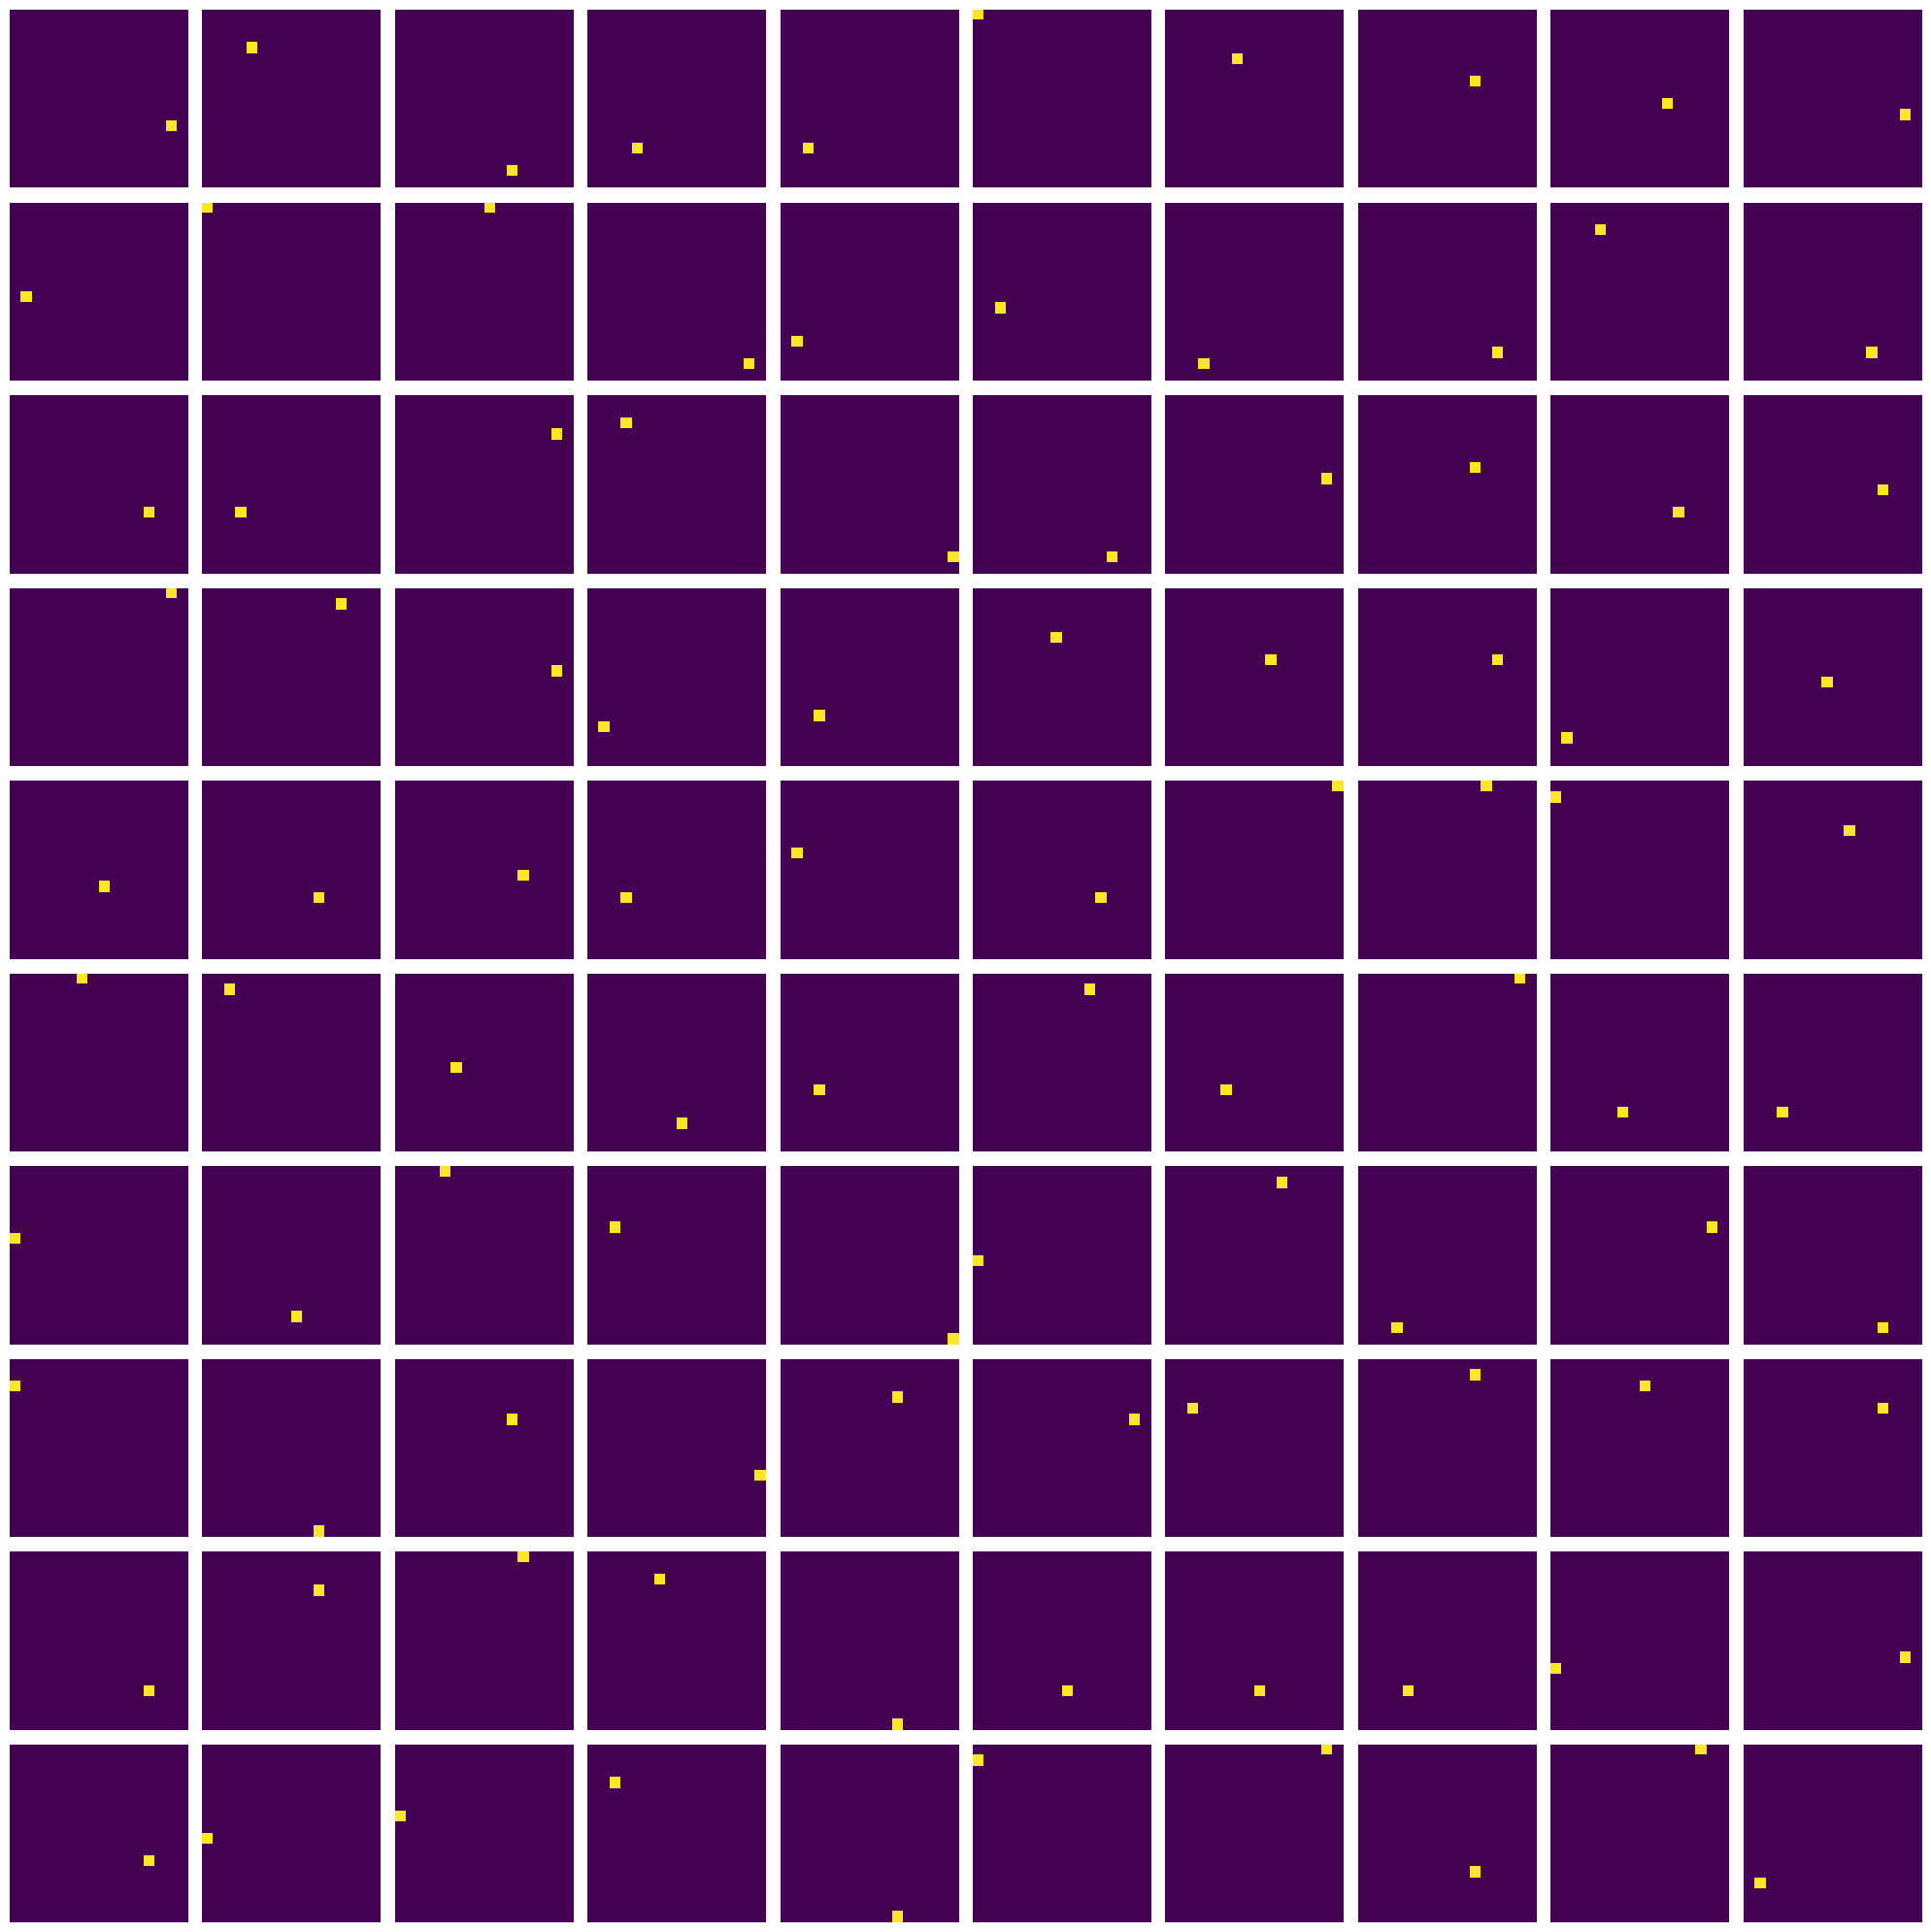

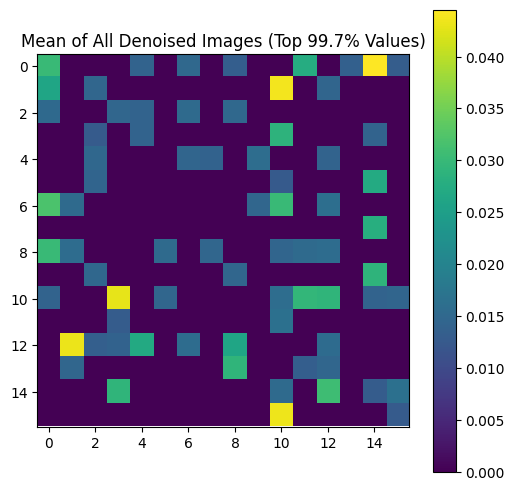

FID  2.5632934338133335
SSIM  0.4680990603713551
Wasserstein  0.0036396250640973447


In [48]:
def plot_decoded_images_without_noise(decoded_images, grid_size=(4, 4), threshold_percent=90):
    num_images = decoded_images.shape[0]
    denoised_images = []

    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(20, 20))

    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            if (i * grid_size[1] + j) < num_images:
                image = decoded_images[i * grid_size[1] + j]

                threshold = np.percentile(image, threshold_percent)

                image_without_noise = np.where(image > threshold, image, 0.0)

                denoised_images.append(image_without_noise)

                axes[i, j].imshow(image_without_noise, cmap='viridis')
                axes[i, j].axis('off')
            else:
                axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

    denoised_images = np.array(denoised_images)
    mean_denoised_image = np.mean(denoised_images, axis=0)

    plt.figure(figsize=(6, 6))
    plt.imshow(mean_denoised_image, cmap='viridis')
    plt.title(f"Mean of All Denoised Images (Top {threshold_percent}% Values)")
    plt.colorbar()
    plt.show()

    return denoised_images

denoised_images = plot_decoded_images_without_noise(new_images, grid_size=(10, 10), threshold_percent=99.7)

mu_real, sigma_real = calculate_statistics(real_data)
mu_gen, sigma_gen = calculate_statistics(denoised_images)
fid = calculate_fid(mu_real, sigma_real, mu_gen, sigma_gen)
print("FID ", fid)

ssim_value = calculate_ssim(real_data, denoised_images)
print("SSIM ", ssim_value)

wasserstein_value = calculate_wasserstein(real_data, denoised_images)
print("Wasserstein ", wasserstein_value)